Start by importing all of the packages that we are going to be using. I import visualizations, a python file that I've created, which contains a bunch of functions that produce visualizations to help with visualizing our data, and assessing our models. 

In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report,precision_score, precision_recall_fscore_support as score, f1_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import FeatureAgglomeration
from sklearn import cluster
from imblearn.over_sampling import SMOTE
import keras
from keras import models
from keras import layers
from keras.utils.np_utils import to_categorical  
import keras.backend as K
from keras.callbacks import Callback
import itertools
from visualizations import *

Using TensorFlow backend.


# Data Visualization and Analysis of Credit Card Fraud Data

## Getting the Data

The dataset that we're going to be looking at today can be found on [Kaggle](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). It's a dataset of credit card transactions, and each one is marked as either a legitimate or a fraudulent transaction. We're going to see if we can use the information given to predict whether or not a transaction is legitimate.

Before building and sort of predictive model, we're going to want to load the data (I saved mine to a csv file called 'fraud.csv'), check for any null values in the data, and get a sense for what each column of data looks like. As explained on Kaggle, we have 28 continuous principal components of a credit card transaction dataset, the time of the transaction (measured in seconds from the time of the first transaction), and the amount of the transaction.

In [2]:
fraud = pd.read_csv('fraud.csv')
fraud.info()
fraud.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Exploration and Visualization

### The output

We're going to start by digging in to what this data actually *looks* like. A natural first place to start looking is how our output is distributed. It's pretty clear that a majority of the transactions in the dataset are legitimate, with only 0.172% of them marked as fraud. This will have some serious implications for how we go about building our model.

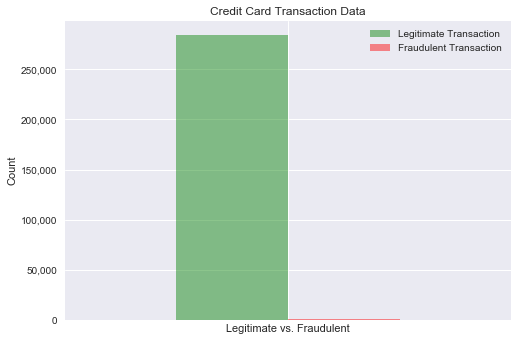

In [3]:
fraud_output = pd.DataFrame(columns = ['Legitimate Transaction', 'Fraudulent Transaction'])
counts = fraud['Class'].value_counts()
fraud_output.loc[0] = [counts[0],counts[1]]
bars = fraud_output.plot.bar(title = 'Credit Card Transaction Data', color = ['green','red'], alpha = 0.45)
bars.set_xlabel('Legitimate vs. Fraudulent')
plt.tick_params(labelbottom='off')  
bars.set_ylabel('Count')
bars.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

### The Inputs

#### Amount

Lets start by looking at the amount of each transaction. Visualization of the amount histograms doesn't do too much for us, but we can note that the amount for the fraudulent transactions tends to be higher than that of the legitimate ones.

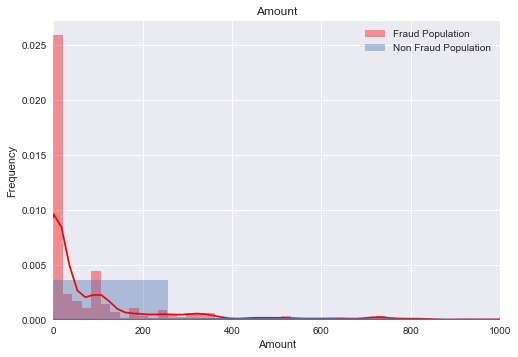

In [4]:
plot_cts_hist(fraud, 'Amount', 'Class', 100, 'Fraud', zoom = [0,1000]).show()
plt.close()

In [5]:
fraud.groupby('Class')['Amount'].mean()

Class
0     88.291022
1    122.211321
Name: Amount, dtype: float64

In [6]:
fraud.groupby('Class')['Amount'].std()

Class
0    250.105092
1    256.683288
Name: Amount, dtype: float64

#### Principal Components

Next lets look at the principal components that we are given. Since we don’t know what the principal components represent (by design of the dataset’s publisher), all we can really do is plot the distribution of each principal component. 

For the purposes of identifying fraudulent transactions it makes the most sense to plot the normalized (since the dataset is so imbalanced) frequency distributions of fraudulent transactions vs. legitimate transactions for each principal component. There are 28 of them, which I display below.

I found that the most interesting visualizations were produced by principal components 1, 2, 3, 4, 7, 9, 10, 11, 12, 14, 16, 17, 18, and 19. Generally speaking, the distributions that I found interesting fell into two main categories.

1. The means of each category were only slightly different, but the fraudulent transactions deviated from their mean far more than the legitimate ones did, resulting in a longer tail

2. The means of each category were very different, and the fraudulent transactions also displayed more spread out distributions, resulting in a longer tail

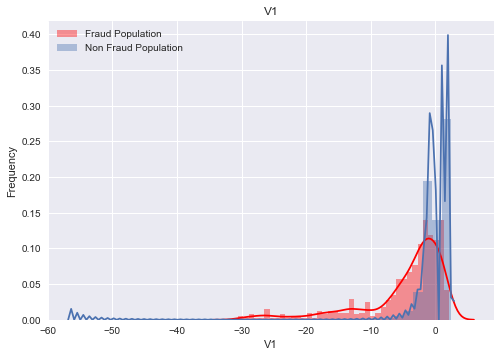

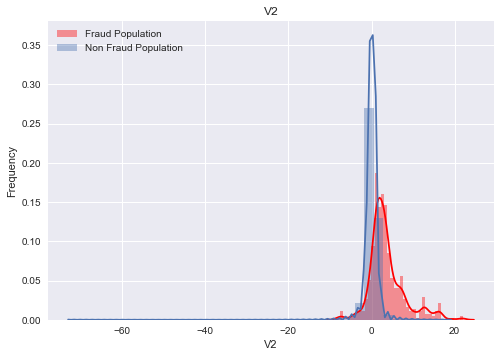

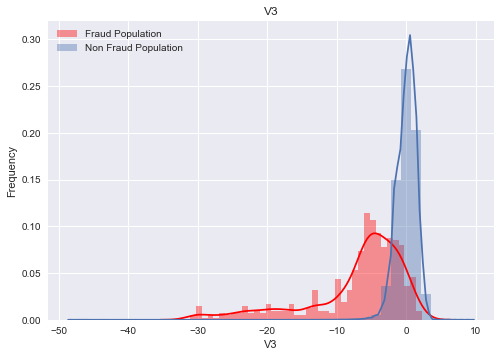

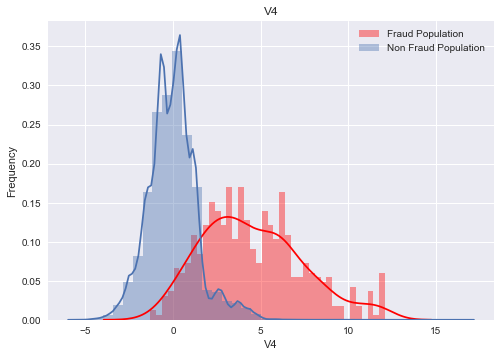

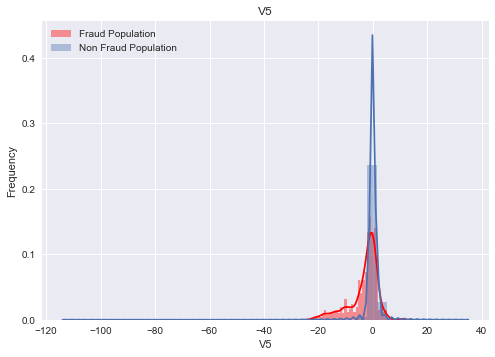

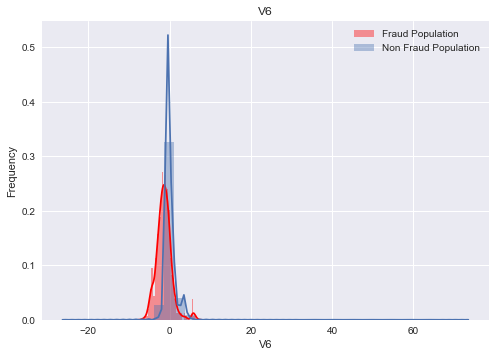

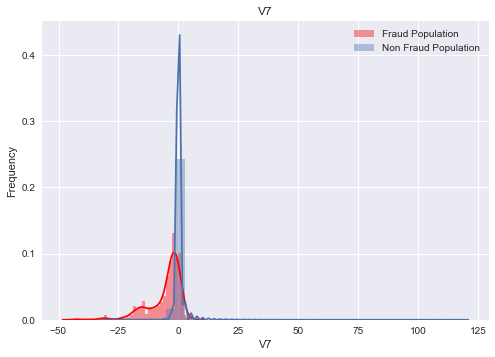

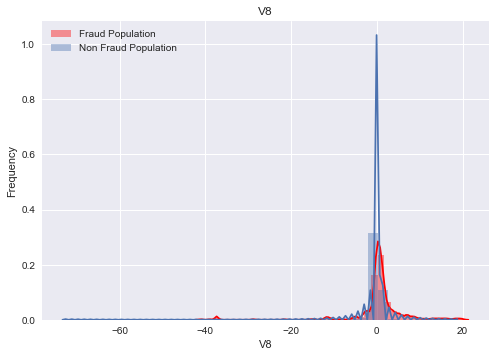

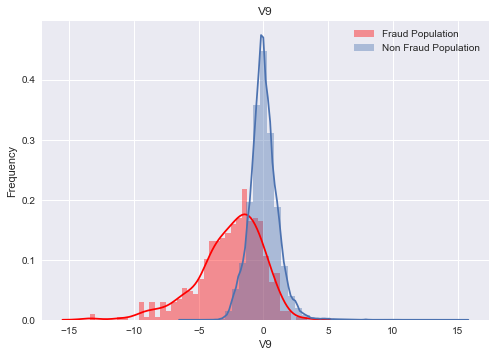

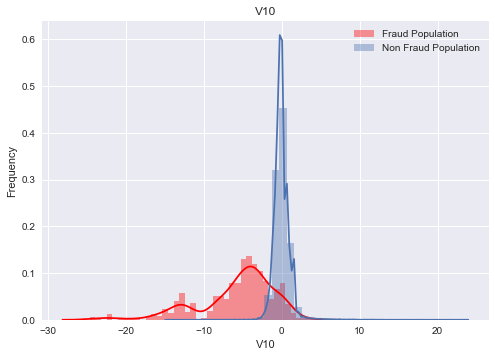

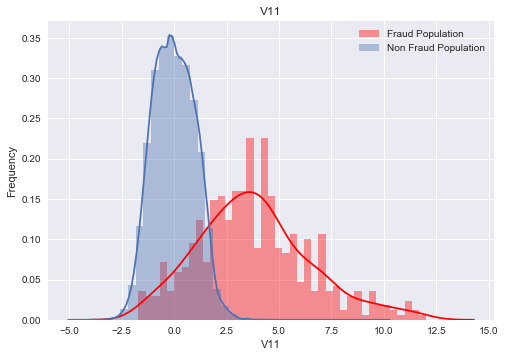

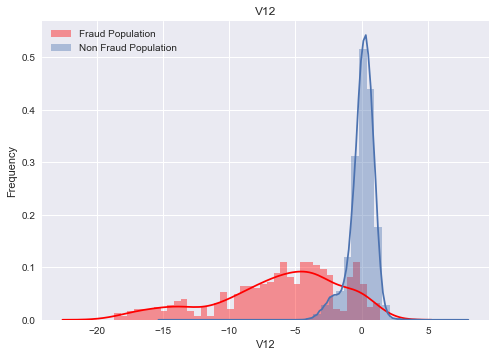

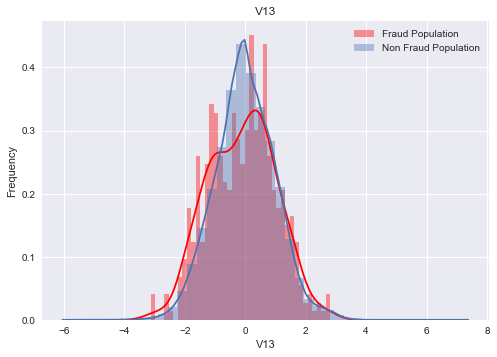

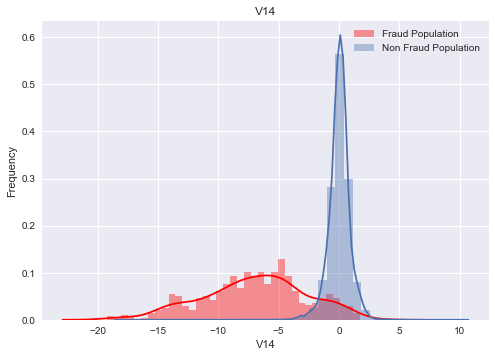

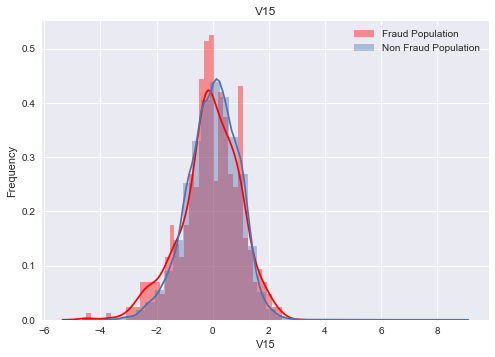

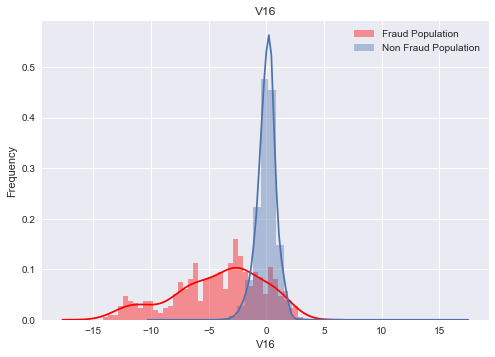

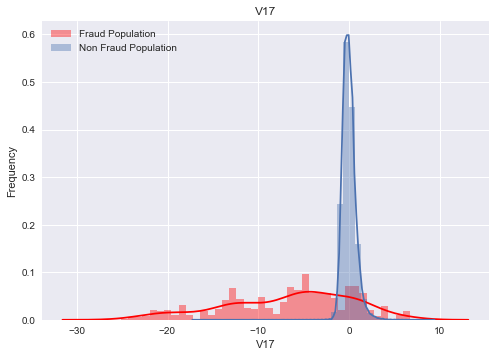

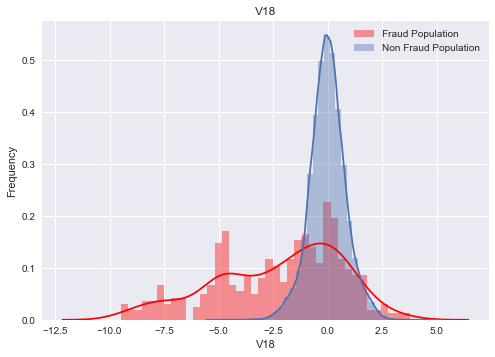

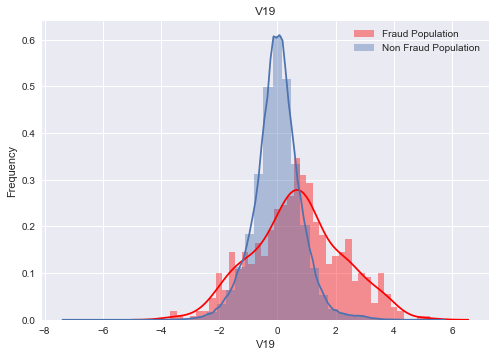

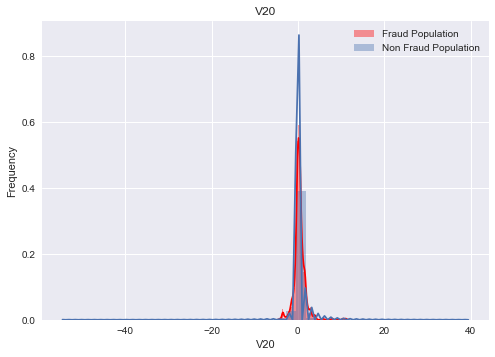

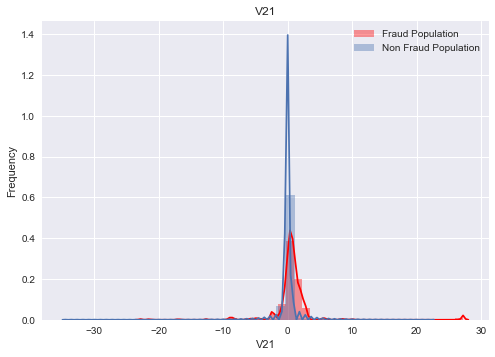

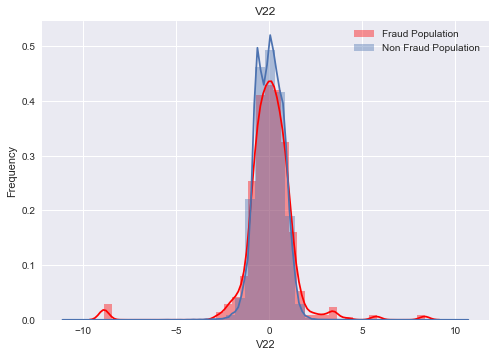

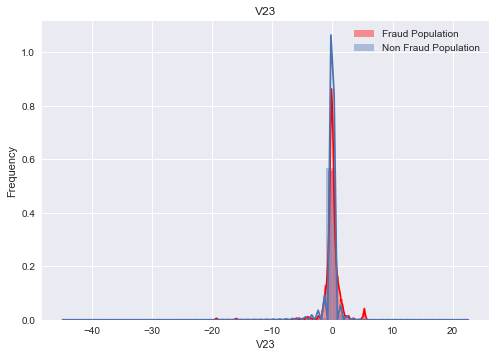

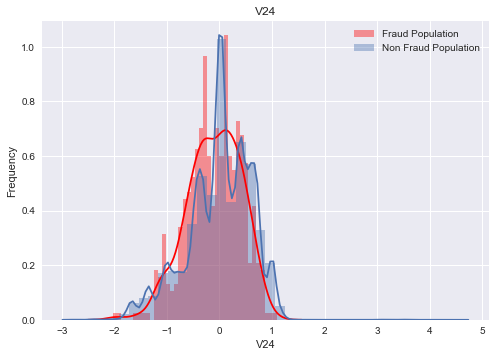

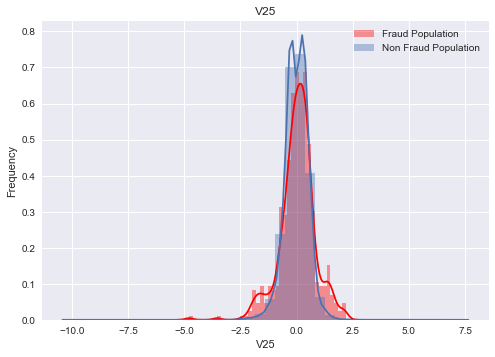

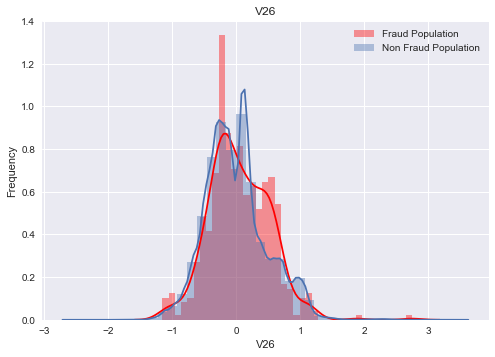

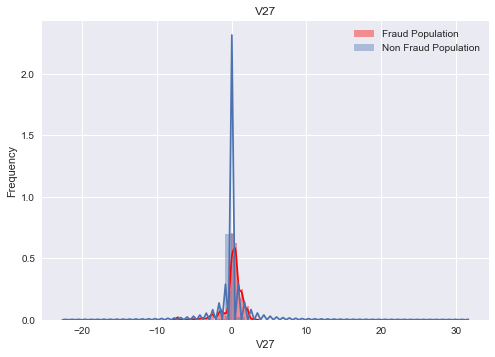

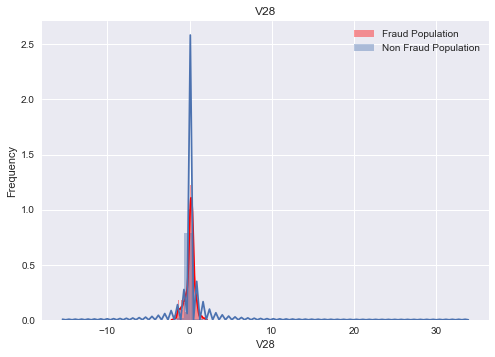

In [7]:
for i in range(1,29):
    plot_cts_hist(fraud,'V' + str(i), 'Class', 40,'Fraud').show()
    plt.close()

#### The Time Series

Next we should visualize the data as a time series. Plotting the principal components over time probably won't yield much, but we could plot our output over time to see if we can pick up any patterns in when fraudulent transactions take place. 

Firstly, it seems like the dataset only spans two days of transactions, and it's pretty clear that there is a cycle taking place. It looks like there is a 6 or 7 hour period of each day where legitimate transactions happen rarely, but the fraudulent transactions seem to not follow this same rule. These hours are likely late night/early morning hours of the day. 

Next I plot the fraud vs. legitimate transactions by minute of the day. This visualization will not show the cyclical nature of our dataset, but it will further confirm the difference in patterns between the legitimate/fraudulent transactions highlighted above. 

In [8]:
fraud['Second of Day'] = fraud['Time'] % (60*60*24)
fraud['Minute of Day'] = round(fraud['Second of Day'] / (60),0)

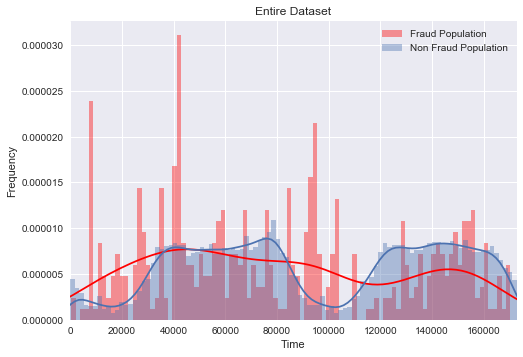

In [9]:
plot_cts_hist(fraud, 'Time', 'Class', 100, 'Fraud', zoom = [0,fraud['Time'].max()],title = 'Entire Dataset').show()

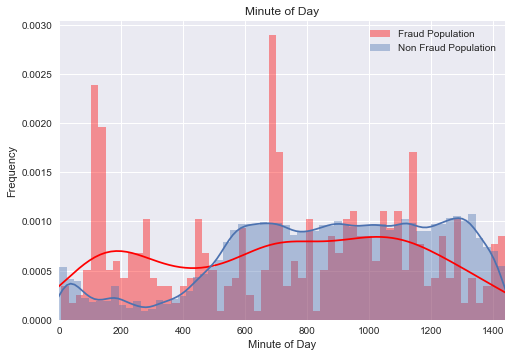

In [10]:
plot_cts_hist(fraud, 'Minute of Day', 'Class', 60, 'Fraud', zoom = [0,1440]).show()

## Preprocessing and Predictive Modeling

We begin by splitting the data into training, validation, and testing sets. For a good description of the type of methodology we are going to be employing for training, validating, and testing throughout our hyperparameter tuning, check out [these Stanford lecture notes](http://cs231n.github.io/classification/#val). 

Next we take the mean and standard deviation of the training data and use it to normalize both the training, validation, and testing data. We do not include the observations in the test/val set in our calculations of the mean and the standard deviation to avoid overfitting the testing or validation data.

In [11]:
X = fraud.drop(['Class', 'Second of Day', 'Minute of Day'],axis=1)
Y = fraud['Class']

X_tr, X_val_tr, Y_tr, Y_val_tr = train_test_split(X, Y, test_size=0.3)
X_val, X_te, Y_val, Y_te = train_test_split(X_val_tr, Y_val_tr, test_size = 0.5)

X_tr = X_tr.values.astype('float32')
X_te = X_te.values.astype('float32')
X_val = X_val.values.astype('float32')
Y_tr = Y_tr.values.astype('float32')
Y_te = Y_te.values.astype('float32')
Y_val = Y_val.values.astype('float32')

mean = X_tr.mean(axis=0)
X_tr -= mean
X_te -= mean
X_val -= mean
std = X_tr.std(axis=0)
X_tr /= std
X_te /= std
X_val /= std

### Objective

Before we begin modeling we must note that the output is very unbalanced. This has serious implications for how we are going to need to tune our hyperparameters, and we will explore several ways to tune a model to better handle this sort of output. 

Since we are dealing with skewed data, we can’t just report on a models raw accuracy (correct guesses / total guesses). We must also rely on classification reports and confusion matrices to get the full picture of how well our model is performing. 

The two statistics in the classification reports that we monitor most closely are the precision and the recall for each class. Regardless of class both values are going to live in the range [0,1]. Precision tells us how accurate we are when we guess a certain category (regardless of whether or not we’ve captured every observation of that category). Recall, on the other hand, tells us what percentage of a given category we were able to pick up with in our model (regardless of how accurate we are in our predictions). Because over 99% of the observations are legitimate transactions the recall of category 0 is also a good proxy for the model's accuracy.

Before we get into any of the models we should talk a little bit about the actual *cost* of each type of misclassification. When a credit card transaction is marked as fraudulent the credit card company will probably block the transaction and send a text to the cardholder, at which point we’ll know if our model made the correct guess. If the transaction is actually fraudulent, then we caught the bad guy and saved the company some money! The cost of of getting the guess wrong is delaying the cardholder’s transaction by a few seconds.

What about when we guess that the transaction is legitimate? If we’re right then the transaction goes through and everybody is happy. When we’re wrong, on the other hand, we allow a fraudulent transaction to go through which will ultimately cost the cardholder his/her time, and the company their money.

For my analysis I assume that we are trying to get almost all of the fraudulent transactions, while not needing to spend too much time checking up on legitimate transactions. I try to have the cutoff for not needing to "spend too much time" be 95% accuracy. 

### Models

#### SMOTE Oversampling

One thing we can try doing is something called SMOTE, which is short for synthetic minority over-sampling technique. This method is used to make an unbalanced dataset balanced by synthesizing observations of the minority output. In our case, SMOTE is going to generate a bunch of fraudulent transactions that are similar to the ones we have in our dataset.

It does this by first identifying a vector between a fraudulent transaction and one of its nearest neighbors in the feature space (for more on this see the [knn wikipedia page](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)), then it generates a random number in (0,1) and multiplies the vector by that number. We then take this vector which has been scaled down and add it to our original point. What we are left with is a point that exists somewhere on the line between a fraudulent transaction and one of its nearest neighbors.

One final thing to note about SMOTE is that we should not use our testing or validation data to generate any samples. This would cause the model to severely overfit the testing/validation set. I will carry out my analysis on both the raw data and the oversampled data, examining first the original dataset and then the oversampled dataset.

In [12]:
sm = SMOTE(ratio = 'minority')
X_over, Y_over = sm.fit_sample(X_tr, Y_tr)

#### Logistic Regression

#### Raw Data

We start with a simple logistic regression. Logistic regressions are great for binary classification. The out of the box logistic regression performs rather poorly, only being able to pick up on around 59% of the fraudulent transactions - note that it is still almost 100% accurate. 


Clasification report:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     42657
          1       0.83      0.59      0.69        64

avg / total       1.00      1.00      1.00     42721



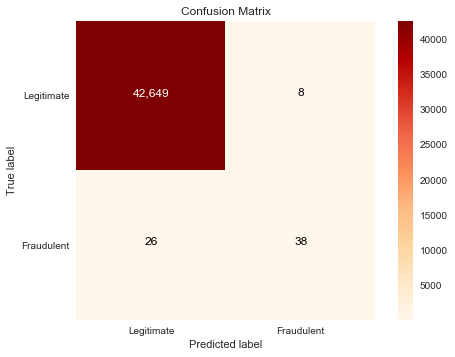

In [13]:
logreg = LogisticRegression()
lr = logreg.fit(X_tr,Y_tr)
predictions = lr.predict(X_val)
plot_confusion_matrix(Y_val,predictions,['Legitimate','Fraudulent']).show()
plt.close()

The first thing I try to tune is the output `class_weight`s which can be specified with the `class_weight` hyperparameter of the logistic regression object. I plot the recall of both outputs as you vary the hyperparameter. This serves to show us how well we are doing at picking up the fraudulent transactions. Since most of our observations are of legitimate transactions, the recall for category 0 informs us on how accurate the model is overall. 

Recall for category 0 as a function of `class_weight` is monotone decreasing, while the recall for category 1 as a function of `class_weight` is monotone increasing. The *optimal* model is one that strikes the right balance between accuracy and fraud detection, so my visualizations serve to narrow our search down to a model that seems sensible considering the cost of incorrectly classifying a transaction as fraudulent vs. legitimate.

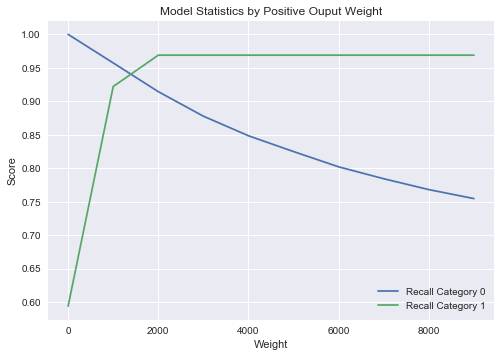

In [14]:
plot_weights(LogisticRegression(),weights = np.arange(1.0, 10000, 1000), X_tr = X_tr, Y_tr = Y_tr, X_te = X_val, Y_te = Y_val, recall = True)

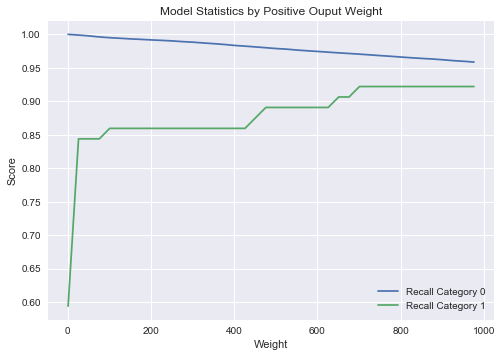

In [15]:
plot_weights(LogisticRegression(),weights = np.arange(1, 1000, 25), X_tr = X_tr, Y_tr = Y_tr, X_te = X_val, Y_te = Y_val, recall = True)

With the help of our visualizations we are able to choose `800` as our `class_weight`. By tuning this hyperparameter we can get our model to pick up 90% of the fraudulent transactions while remaining 96% accurate. 

Model Accuracy:  0.965848177711

Clasification report:
              precision    recall  f1-score   support

          0       1.00      0.97      0.98     42657
          1       0.04      0.92      0.07        64

avg / total       1.00      0.97      0.98     42721



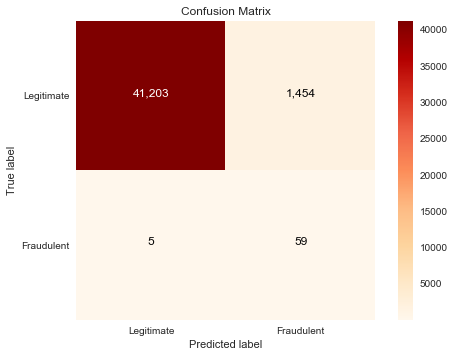

In [39]:
logreg = LogisticRegression(class_weight = {0:1.,1:800})
lr = logreg.fit(X_tr,Y_tr)
predictions = lr.predict(X_val)
print("Model Accuracy: " ,(predictions == Y_val).mean())
plot_confusion_matrix(Y_val,predictions,['Legitimate','Fraudulent']).show()
plt.close()

Now that we've settled on a model we can run it on our testing set. Note that at this point we are no longer interested in tuning hyperparameters, we simply want to see how well our hyperparameter tuning generalizes to data that was not used in model training, and hyperparameter selection. The model generalizes surprisingly well, it is able to pick up 92% of fraudulent transactions while remaining about 97% accurate.

Model Accuracy:  0.967768362904

Clasification report:
              precision    recall  f1-score   support

        0.0       1.00      0.97      0.98     42649
        1.0       0.05      0.92      0.09        73

avg / total       1.00      0.97      0.98     42722



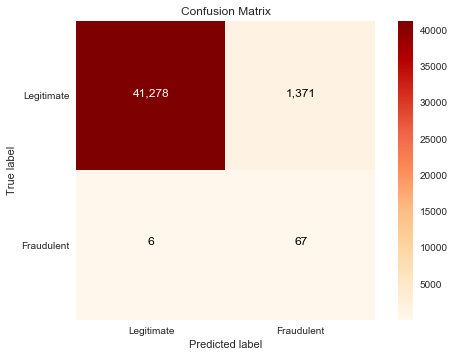

In [40]:
logreg = LogisticRegression(class_weight = {0:1.,1:800})
lr = logreg.fit(X_tr,Y_tr)
predictions = lr.predict(X_te)
print("Model Accuracy: " ,(predictions == Y_te).mean())
plot_confusion_matrix(Y_te,predictions,['Legitimate','Fraudulent']).show()
plt.close()

The next thing we can do is utilize the fact that what our logistic regression actually outputs a probability distribution for the output. By default we take the larger of the two probabilities and guess that as the ouput. What we can do is, instead, change the cutoff value for when we begin classifying an observation as fraud. I plot some model statistics as you vary the cutoff. It seems like our original approach gets better results, so I omit any model outputs for specific cutoffs. 

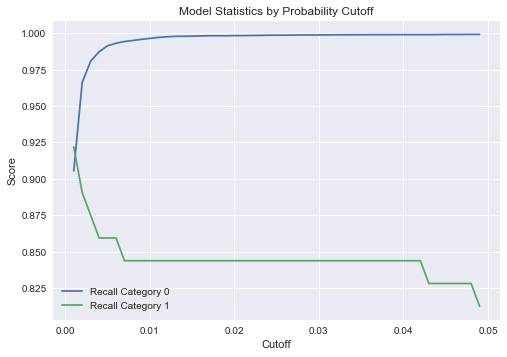

In [17]:
plot_cutoffs(LogisticRegression(),cutoffs = np.arange(0.001,.05,.001), X_tr = X_tr, Y_tr = Y_tr, X_te = X_val, Y_te = Y_val, recall = True)

#### Oversampled Data

Right out of the box we can see that our logistic regression is performing better after the oversampling. This is because we are now training our data on a balanced (synthetically, at least) dataset, but we were still able to do better with our `class_weight` hyperparameter above. 

Model Accuracy:  0.973994054446

Clasification report:
              precision    recall  f1-score   support

          0       1.00      0.97      0.99     42657
          1       0.05      0.88      0.09        64

avg / total       1.00      0.97      0.99     42721



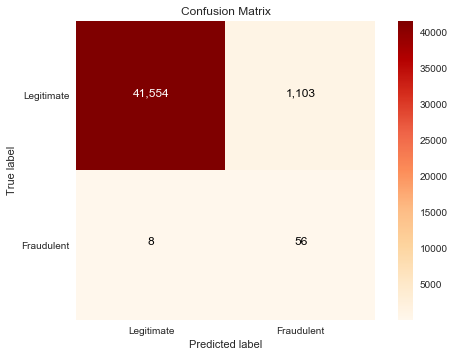

In [18]:
logreg = LogisticRegression()
lr = logreg.fit(X_over,Y_over)
predictions = lr.predict(X_val)
print("Model Accuracy: " ,(predictions == Y_val).mean())
plot_confusion_matrix(Y_val,predictions,['Legitimate','Fraudulent']).show()
plt.close()

We can try to do the same thing again, while keeping in mind that such a high weight probably wont be necessary. We find that we can get just about the same performance as we did previously, except with a `class_weight` of only `1.9`. It seems that our SMOTE oversampling may not have been that effective in increasing the performance of our logistic regression.

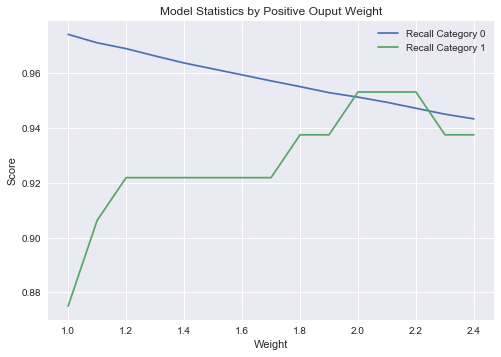

In [19]:
plot_weights(LogisticRegression(),weights = np.arange(1.0, 2.5, .1), X_tr = X_over, Y_tr = Y_over, X_te = X_val, Y_te = Y_val, recall = True)

Model Accuracy:  0.95285690878

Clasification report:
              precision    recall  f1-score   support

          0       1.00      0.95      0.98     42657
          1       0.03      0.94      0.06        64

avg / total       1.00      0.95      0.97     42721



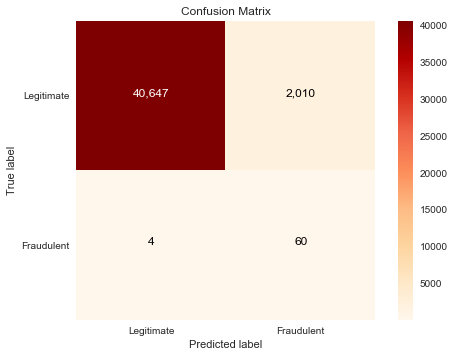

In [20]:
logreg = LogisticRegression(class_weight = {0:1.,1:1.9})
lr = logreg.fit(X_over,Y_over)
predictions = lr.predict(X_val)
print("Model Accuracy: " ,(predictions == Y_val).mean())
plot_confusion_matrix(Y_val,predictions,['Legitimate','Fraudulent']).show()
plt.close()

The logistic regression trained on the oversampled data generalizes well on the testing data. The model performs just about the same as the logistic regression trained on the un-oversampled data, but it might be worth noting that it is slightly better at picking up the fraudulent transactions - it has 93% recall on fraudulent transactions.

Model Accuracy:  0.955362576658

Clasification report:
              precision    recall  f1-score   support

        0.0       1.00      0.96      0.98     42649
        1.0       0.03      0.93      0.07        73

avg / total       1.00      0.96      0.98     42722



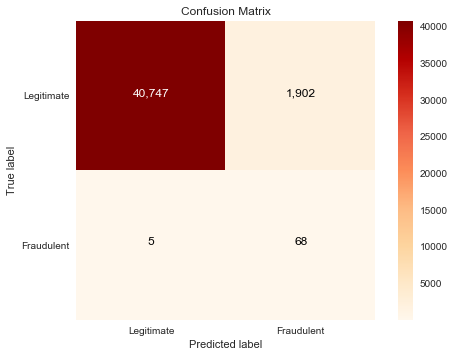

In [41]:
logreg = LogisticRegression(class_weight = {0:1.,1:1.9})
lr = logreg.fit(X_over,Y_over)
predictions = lr.predict(X_te)
print("Model Accuracy: " ,(predictions == Y_te).mean())
plot_confusion_matrix(Y_te,predictions,['Legitimate','Fraudulent']).show()
plt.close()

It looks like our cutoff methodology performs better on the oversampled data. The model produced by varying the cutoff performs just about the same as our other optimized models.

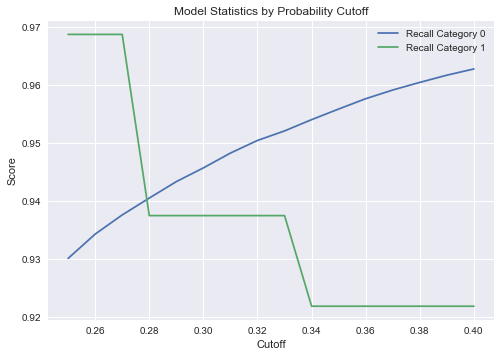

In [21]:
plot_cutoffs(LogisticRegression(), np.arange(.25,0.4,.01), X_over, Y_over, X_val, Y_val, recall = True)

#### Random Forest Classifier

The next classifier we are going to look at is the random forest classifier. These are good at constructing decision trees which are great for solving categorization problems.

#### Raw Data

Model Accuracy:  0.999531846165

Clasification report:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     42657
          1       0.94      0.73      0.82        64

avg / total       1.00      1.00      1.00     42721



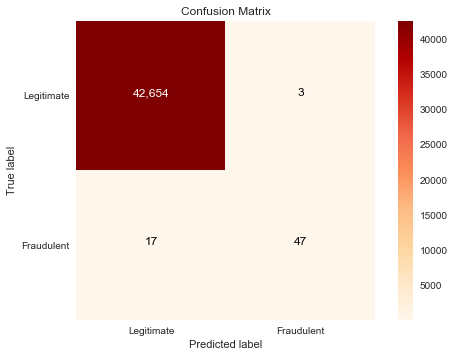

In [22]:
clf = RandomForestClassifier()
clf = clf.fit(X_tr,Y_tr)
predictions = clf.predict(X_val)
print("Model Accuracy: " ,(predictions == Y_val).mean())
plot_confusion_matrix(Y_val,predictions,['Legitimate','Fraudulent']).show()
plt.close()

Instead of using a GridSearch which would assess our models based on accuracy, I chose to approach my search for the correct hyperparameters visually. I employ a similar methodology in which I vary my hyperparameters and plot the recall statistics for each model. It seems like we can get some small increases by varying our hyperparameters, but none of the models produced come even close to the ones we constructed earlier. 

It looks like the model stops improving after 50 estimators.

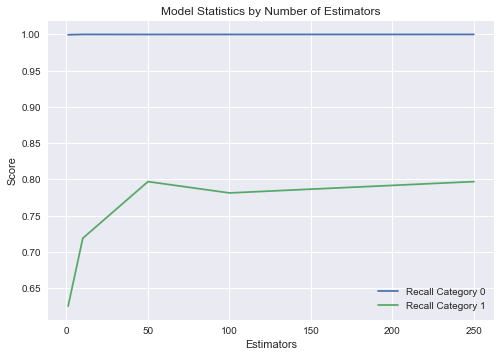

In [23]:
rfc_n_estimators([1,10,50,100,250],X_tr,Y_tr,X_val,Y_val, recall = True)

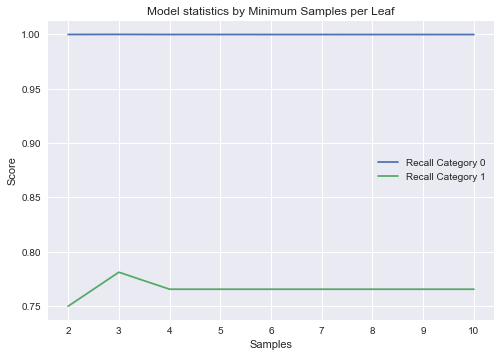

In [24]:
rfc_min_samples_leaf([2,3,4,10],X_tr,Y_tr,X_val,Y_val, recall = True)

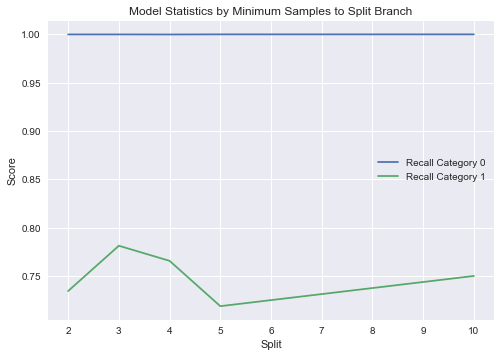

In [25]:
rfc_min_samples_split([2,3,4,5,10],X_tr,Y_tr,X_val,Y_val, recall = True)

Surprisingly changing the weight for the positive output has almost no (if not negative) effect on the models ability to detect fraud.

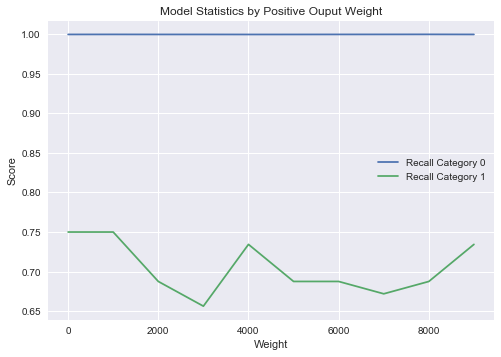

In [26]:
plot_weights(RandomForestClassifier(),weights=np.arange(1.0, 10000, 1000), X_tr = X_tr, Y_tr = Y_tr, X_te = X_val, Y_te = Y_val, recall = True)

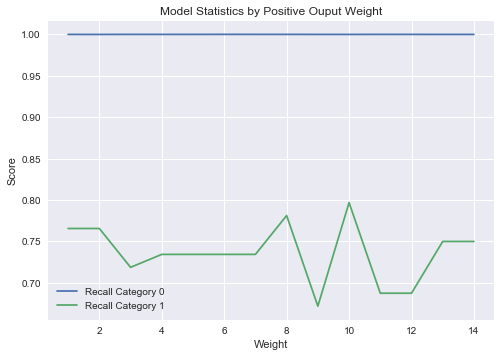

In [27]:
plot_weights(RandomForestClassifier(),weights=np.arange(1.,15.,1.), X_tr = X_tr, Y_tr = Y_tr, X_te = X_val, Y_te = Y_val, recall = True)

#### Oversampled data

Next we turn to our oversampled data. The out of the box random forest performs slightly better than with the provided data, but there isn't really that significant of an improvement. I reproduce the analysis that I did above, except with the oversampled data to find very similar results. The efforts that I made in tuning the hyperparameters of the random forest produced lackluster results, and I was unable to come close to the performance achieved by the logistic regression. 

I leave the output graphs of my hyperparameter tuning for the reader.

Model Accuracy:  0.999414807706

Clasification report:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     42657
          1       0.82      0.78      0.80        64

avg / total       1.00      1.00      1.00     42721



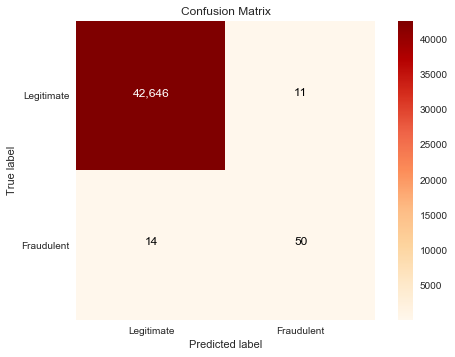

In [28]:
clf = RandomForestClassifier()
clf = clf.fit(X_over,Y_over)
predictions = clf.predict(X_val)
print("Model Accuracy: " ,(predictions == Y_val).mean())
plot_confusion_matrix(Y_val,predictions,['Legitimate','Fraudulent']).show()
plt.close()

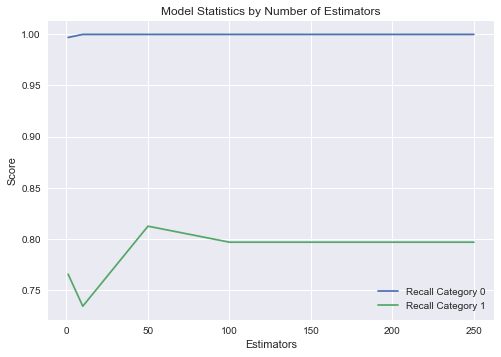

In [29]:
rfc_n_estimators([1,10,50,100,250],X_over,Y_over,X_val,Y_val, recall = True)

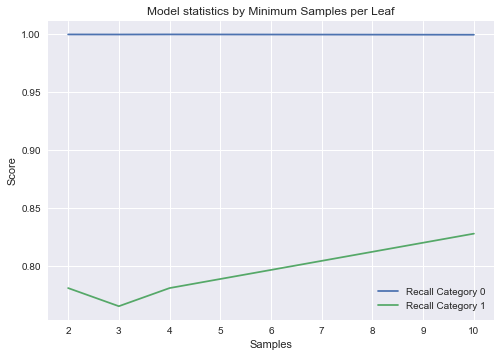

In [30]:
rfc_min_samples_leaf([2,3,4,10],X_over,Y_over,X_val,Y_val, recall = True)

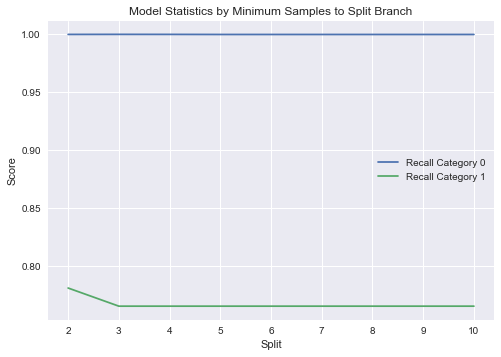

In [36]:
rfc_min_samples_split([2,3,4,5,10],X_over,Y_over,X_val,Y_val, recall = True)

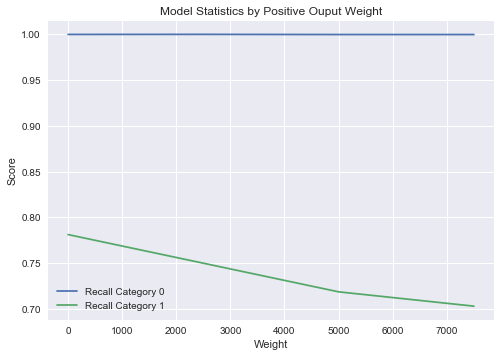

In [43]:
plot_weights(RandomForestClassifier(),weights=np.arange(1.0, 10000, 2500), X_tr = X_over, Y_tr = Y_over, X_te = X_val, Y_te = Y_val, recall = True)

In [ ]:
plot_weights(RandomForestClassifier(),weights=np.arange(1.,16.,1), X_tr = X_over, Y_tr = Y_over, X_te = X_val, Y_te = Y_val, recall = True)

In [ ]:
clf = RandomForestClassifier(n_estimators=50,class_weights={0:1.,1:11},min_samples_split=10,min_samples_leaf=10)
clf = clf.fit(X_over,Y_over)
predictions = clf.predict(X_te)
print("Model Accuracy: " ,(predictions == Y_te).mean())
plot_confusion_matrix(Y_te,predictions,['Legitimate','Fraudulent']).show()
plt.close()

#### Neural Network

Next we are going to try a neural network. If you haven't picked up on this yet, we really care about our model's ability to recall those fraudulent transactions. Unfortunately, Keras doesn't have a built in way to report on the recall statistics. They used to, but in the last release it was removed because it was calculated batchwise, which resulted in model statistic that wasn't interpritable. 

Instead we monitor the recall statistic as calculated at the end of every epoch in order to monitor how well the model is performing while training. Recall that a neural network is optimized to maximize the model accuracy and minimize the loss. But for us, the recall statistic is just as important as the model accuracy. As our model trains the accuracy may increase at the cost of our recall decreasing. This makes our ability to monitor recall over epochs instrumental in determining when to stop training our model.

We define a custom callback in Keras in order to get our model to store the recall statistics. When we go to construct our model we have to make sure that we include the metrics in the model callbacks.

**A quick note about this callback: **
The computations in this callback can get pretty expensive and take a lot of time depending on your setup, how complex your model is, and how complex your dataset is. For the purposes of plotting the statistics at the end of training while hyperparameter tuning we *do not* need this callback. When we want to get into analyzing how the model is training across epochs we want to include this callback.

In [44]:
class Metrics(Callback):

    def on_train_begin(self, logs={}):
        self.recalls = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        self.recalls.append(recall_score(val_targ,val_predict))
        return

metrics = Metrics()

We're going to be tuning the class weights again, but a deep neural network has so many moving parts that it's hard to pin down what architecture we should be using when we search for our optimal `class_weight`. I first find a suitable network to use in comparing different class weights. I discuss the thought process briefly below.

I typically start with the simplest network and work my way up by adding more layers with more neurons. You want to start simple because it is very easy to have an overly complex model that overfits the data. Eventually, adding layers gives you diminishing returns with respect to model accuracy, and, for our data, I decided that having my first, and largest, layer have 1024 neurons. I have several layers, with each subsequent layer being smaller than the last. I do this because I do not want to compress the information contained in each layer too quickly.

Between each layer I include dropout. When you are optimizing so many model parameters there is a great risk of overfitting the training data. A dropout layer helps us combat this by randomly selecting neurons to turn off between training steps. By doing this, we are able to determine which neurons are actually necessary. We may be constructing an overly complex model by having so many dense layers with so many neurons, but we can rely on dropout to help us trim down our network to a final product that is better at generalizing to data it has not yet seen. 

We also include batch normalization. The input benefits tremendously from being normalized, as would the values being passed through the hidden layers. Batch normalization normalizes the values being passed through each hidden layer, which really speads up training.

Because we are going to be training so many DNN's with so many different weights we need to pick a reasonable number of epochs to use, otherwise training will take too long. I choose 25, but leave the number of epochs as a function input. We also impose an early stopping condition that says that if our model stops improving over 2 epochs that we kill training. 

In [71]:
def dnn_1024(X_tr,Y_tr,X_te, Y_te, epochs, weight, verbose = 1, early_stop = True, optimizer = keras.optimizers.RMSprop()):
    model = models.Sequential()
    model.add(layers.Dense(1024, activation='relu', input_shape=(X_tr.shape[1],)))
    model.add(keras.layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))


    model.compile(optimizer = optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    if early_stop:
        callbacks = [keras.callbacks.EarlyStopping(monitor = 'acc',patience = 2), metrics]
    else:
        callbacks = [metrics]

    history = model.fit(X_tr,
                        Y_tr,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(X_te, Y_te),
                        callbacks = callbacks,
                        class_weight = {0:1., 1:weight},
                        verbose = verbose
                        )
    predictions = model.predict_classes(X_te)
    
    return history, metrics, predictions

#### Raw Data

We begin by plotting the model statistics as you vary weight. Because there's a lot of training involved in the creation of these visualizations I keep the early stopping condition (I will later turn it off so we can see how training takes place over each epoch). 

I start out with a pretty wide range just to get an idea of how the model's accuracy and recall changes as you really start to weight the positive output heavily. Surprisingly the accuracy makes a rebound as you increase the weights significantly.

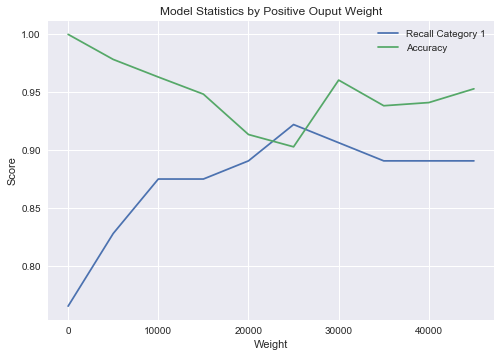

In [66]:
plot_weights_dnn(25,np.arange(1,50000,5000),X_tr,Y_tr,X_val,Y_val)

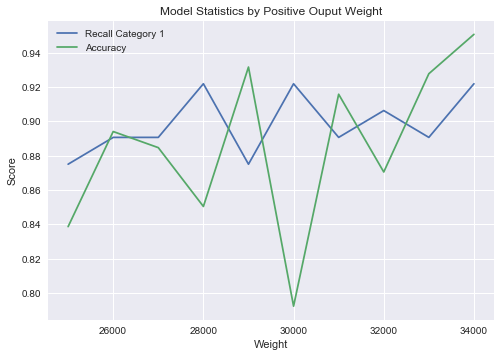

In [67]:
plot_weights_dnn(25,np.arange(25000,35000,1000),X_tr,Y_tr,X_val,Y_val)

I'm able to use our visualizations to first narrow my search down, and then ultimately settle on a class weight of `3400`. I then use my callback to determine that the model does not need to train for so many epochs, and only train the model for 3 epochs. The model generalizes to the testing data nicely. This model is probably the best model we've seen today (with the Logistic Regressions performing almost as well). We are able to keep the model over 97% accurate while picking up 92% of the fraudulent transactions.

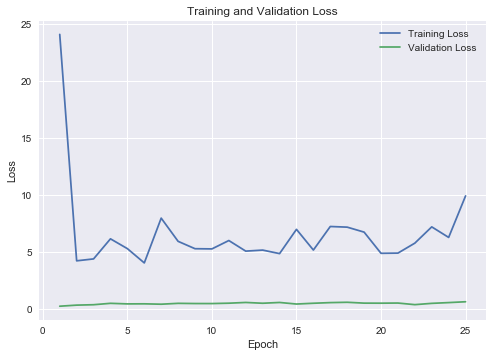

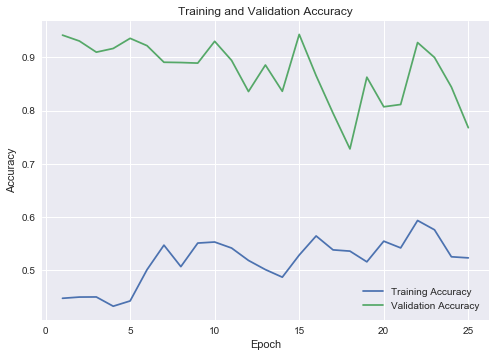

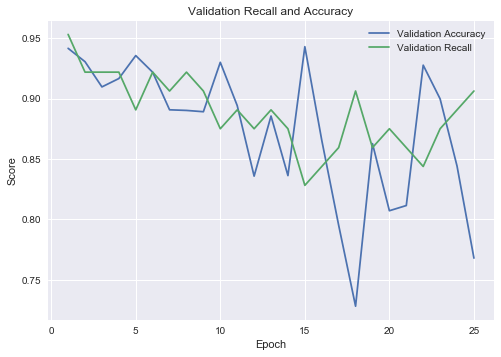

In [69]:
history, metrics, predictions = dnn_1024(X_tr,Y_tr,X_val, Y_val, 25, 34000, verbose = 0, early_stop = False)
dnn_plots(history,metrics)

Model Accuracy:  0.971838288946

Clasification report:
              precision    recall  f1-score   support

        0.0       1.00      0.97      0.99     42649
        1.0       0.06      0.92      0.11        73

avg / total       1.00      0.97      0.99     42722



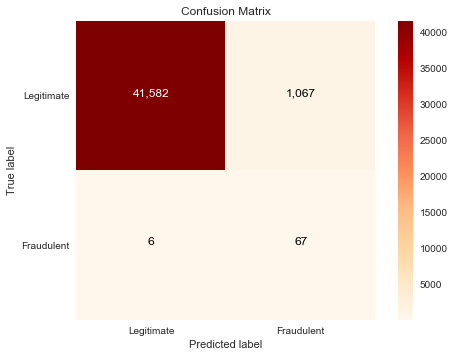

In [72]:
history, metrics, predictions = dnn_1024(X_tr,Y_tr,X_te, Y_te, 3, 34000, verbose = 0, early_stop = False)
print("Model Accuracy: " ,(predictions == Y_te).mean())
plot_confusion_matrix(Y_te,predictions,['Legitimate','Fraudulent']).show()
plt.close()

#### Oversampled Data

We employ the same methodology as the one above in order to determine where the sweet spot for our class weight is going to be. Again, it seems like we need to keep `class_weight` under `2500` if we need to keep that accuracy above 95%. 

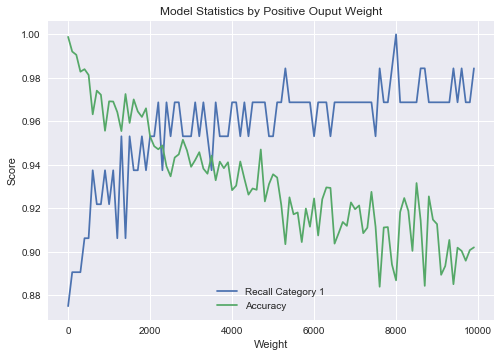

In [79]:
plot_weights_dnn(25,np.arange(1,10000,100),X_over,Y_over,X_val,Y_val)

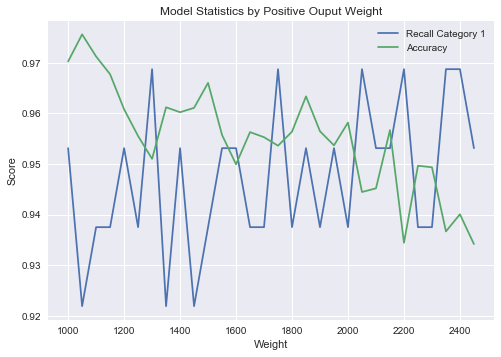

In [81]:
plot_weights_dnn(25,np.arange(1000,2500,50),X_over,Y_over,X_val,Y_val)

Looks like we reach a maximum for our recall at around `1750`. Lets take a deeper look at how a model trains when it has its `class_weight` hyperparameter set to the dictionary `{0: 1., 1: 1750}`. We're going to look at how the accuracy and the recall changes over training epochs. We also should monitor the model's loss and accuracy on both the training and testing data. 

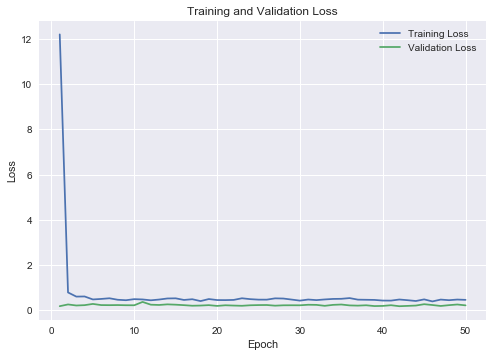

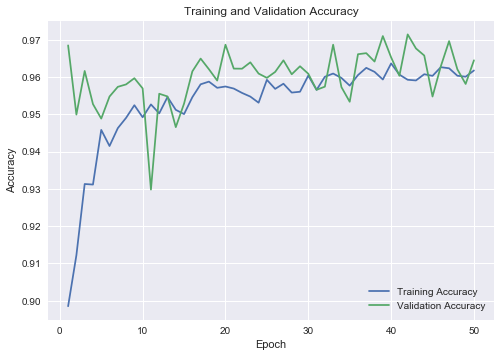

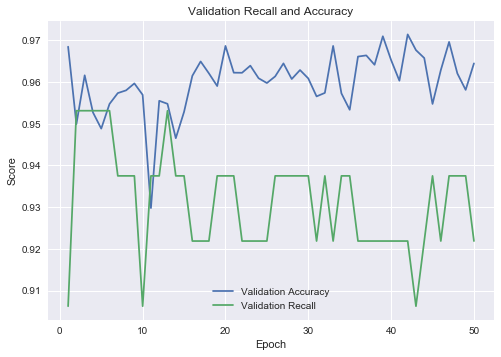

In [82]:
history, metrics, predictions = dnn_1024(X_over,Y_over,X_val, Y_val, 50, 1750, verbose = 0, early_stop = False)
dnn_plots(history,metrics)

Judging by the graphs above it looks like we can stop training after 12 epochs. If we rerun the same model and stop training after the 12th epoch we get lackluster results. This model does not perform/generalize as well as the other neural network. 

Model Accuracy:  0.954646178453

Clasification report:
              precision    recall  f1-score   support

        0.0       1.00      0.96      0.98     42649
        1.0       0.04      0.90      0.07        73

avg / total       1.00      0.96      0.98     42722



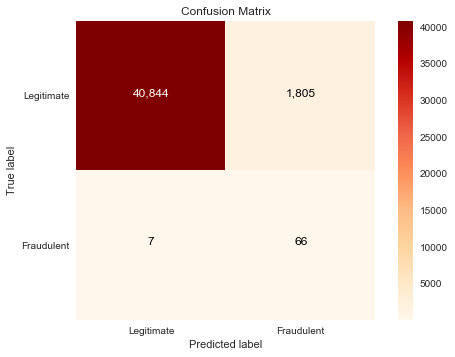

In [85]:
history, metrics, predictions = dnn_1024(X_over,Y_over,X_te, Y_te, 12, 1750, verbose = 0, early_stop = False)
print("Model Accuracy: " ,(predictions == Y_te).mean())
plot_confusion_matrix(Y_te,predictions,['Legitimate','Fraudulent']).show()
plt.close()

## Conclusion

After some exploration and visualization of the data and a whole lot of trial and error with hyperparameter tuning we were able to come to some effective models. We tuned our models by varying many hyperparameters, and given the nature of our problem we found some very useful results in the `class_weight` hyperparameter. With such skewed output we needed to place a significantly higher weight on the positive output class. Another way that we tried to tackle the distribution of our output was to synthesize observations of fraud using SMOTE. With most of our models the results achieved by tuning the weights were just about as good as the results we achieved using SMOTE and hyperparameter tuning.

In all cases except that of the random forest we were able to really increase the accuracy and recall of our models by tuning the `class_weight`. Our most accurate models came with the neural networks where we were able to use deep learning and our visual aids to determine the optimal weights and model architecture. While our models are accurate (over 97% accurate, while being able to pick up over 92% of fraudulent transactions), we should also note that we have a small dataset here, only featuring 2 days of credit card activity. With a larger dataset, and some retraining once the model is in production, we would likely be able to come very close to identifying all of the fraud without misclassifying too many legitimate transactions. 

It should also be noted that we are at risk of overfitting our models to our testing set when we go to such lengths to tune our hyperparameters, and then settle on a final model to put into production based on how well the tuning works on the testing set. Using visual aids and the data we are given to fine tune our models is, however, a good place to start when first tackling a modeling problem like this. With more data (and observations of fraud), we can hope to one day get testing sets that will be representative of the actual universe of fraudulent transactions, which will result in models that perform much better in production.